Tutorial sistem rekomendasi sederhana dengan python dan library surprise.
Referensi: https://surprise.readthedocs.io/en/stable/getting_started.html

Install library surprise lebih dulu

In [ ]:
!pip install surprise

     |████████████████████████████████| 11.8 MB 5.0 MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp37-cp37m-linux_x86_64.whl size=1619396 sha256=c0be19c6d1b93336fe7a0f64189284041d039349e05013d68d09c113134b63a0
  Stored in directory: /root/.cache/pip/wheels/76/44/74/b498c42be47b2406bd27994e16c5188e337c657025ab400c1c
Successfully built scikit-surprise


import library surprise

In [ ]:
from surprise import SVD
from surprise import Dataset
from surprise.model_selection import GridSearchCV, ShuffleSplit

import numpy as np
import pandas as pd
import seaborn as sns

Load dataset yang tersedia di library, movielens dataset, berisi rating film dari 900an ke 1600an film. Total rating ada 100.000

In [ ]:
# Use movielens-100K
data = Dataset.load_builtin('ml-100k', prompt=False)

Cek dataset

In [ ]:
dataset = data.build_full_trainset()

In [ ]:
df = pd.DataFrame(dataset.build_testset(), columns=['user_id', 'item_id', 'rating'])

In [ ]:
df.head()

,user_id,item_id,rating
0,196,242,3.0
1,196,393,4.0
2,196,381,4.0
3,196,251,3.0
4,196,655,5.0


In [ ]:
df.describe()

,rating
count,100000.000000
mean,3.529860
std,1.125674
min,1.000000
25%,3.000000
50%,4.000000
75%,4.000000
max,5.000000


In [ ]:
df['user_id'].unique().shape, df['item_id'].unique().shape

((943,), (1682,))

In [ ]:
count_per_rating = df['rating'].value_counts()

Cek distribusi rating

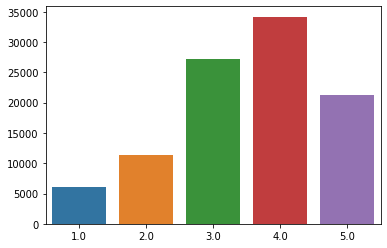

In [ ]:
sns.barplot(x=count_per_rating.index, y=count_per_rating.values)

Tentukan parameter2 yang ingin dites. Parameter2 SVD ada di link ini: https://surprise.readthedocs.io/en/stable/matrix_factorization.html#surprise.prediction_algorithms.matrix_factorization.SVD

In [ ]:
param_grid = {'n_epochs': np.arange(2,11,2), 'lr_all': np.random.uniform(0.002,0.005,5),
              'reg_all': np.arange(0.1,0.6,0.1)}

Jalankan hyperparameter tuning dengan gridsearch

In [ ]:
gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3)

In [ ]:
gs.fit(data)

Cek skor rmse terbaik

In [ ]:
gs.best_score['rmse']

0.9529572325969825

In [ ]:
gs.best_score['mae']

0.7575947465443819

Cek parameter yang menghasilkan skor terbaik

In [ ]:
gs.best_params['rmse']

{'lr_all': 0.004346324863799889, 'n_epochs': 10, 'reg_all': 0.1}

In [ ]:
gs.best_params['mae']

{'lr_all': 0.004346324863799889, 'n_epochs': 10, 'reg_all': 0.1}

cek keseluruhan hasil tuning

In [ ]:
df_results = pd.DataFrame.from_dict(gs.cv_results)

In [ ]:
df_results.head()

,split0_test_rmse,split1_test_rmse,split2_test_rmse,mean_test_rmse,std_test_rmse,rank_test_rmse,split0_test_mae,split1_test_mae,split2_test_mae,mean_test_mae,std_test_mae,rank_test_mae,mean_fit_time,std_fit_time,mean_test_time,std_test_time,params,param_n_epochs,param_lr_all,param_reg_all
0,0.994395,0.997164,0.994217,0.995259,0.001349,98,0.799916,0.800277,0.800084,0.800092,0.000148,94,0.470044,0.019292,0.433495,0.101895,"{'n_epochs': 2, 'lr_all': 0.004346324863799889...",2,0.004346,0.1
1,0.996364,0.998663,0.997177,0.997401,0.000952,101,0.803744,0.804245,0.804719,0.804236,0.000398,99,0.426432,0.016282,0.448252,0.051967,"{'n_epochs': 2, 'lr_all': 0.004346324863799889...",2,0.004346,0.2
2,0.998223,1.001213,0.998460,0.999299,0.001357,102,0.807035,0.807899,0.807313,0.807416,0.000360,102,0.435602,0.016950,0.433716,0.061574,"{'n_epochs': 2, 'lr_all': 0.004346324863799889...",2,0.004346,0.3
3,1.000521,1.004895,1.001463,1.002293,0.001880,104,0.810695,0.812719,0.812340,0.811918,0.000879,105,0.435804,0.003540,0.373851,0.057675,"{'n_epochs': 2, 'lr_all': 0.004346324863799889...",2,0.004346,0.4
4,1.003384,1.007051,1.004156,1.004864,0.001578,106,0.814503,0.816233,0.816129,0.815622,0.000792,108,0.409081,0.016735,0.381946,0.068789,"{'n_epochs': 2, 'lr_all': 0.004346324863799889...",2,0.004346,0.5


Train model dengan parameter terbaik. Dataset dilatih dengan dataset

In [ ]:
model = gs.best_estimator['rmse']
model.fit(dataset)

In [ ]:
test = dataset.build_testset()

Prediksi rekomendasi untuk tiap user

In [ ]:
predictions = model.test(test)

Lihat rekomendasi untuk tiap user

In [ ]:
from collections import defaultdict

In [ ]:
predictions[0]

Prediction(uid='196', iid='242', r_ui=3.0, est=3.9646475619789823, details={'was_impossible': False})

In [ ]:
recommendations = defaultdict(list)
for uid, iid, true_r, est, _ in predictions:
  recommendations[uid].append((iid, est))

In [ ]:
for uid, user_ratings in recommendations.items():
  user_ratings.sort(key=lambda x: x[1], reverse=True)
  recommendations[uid] = user_ratings

Misalnya mau lihat rekomendasi buat user 1

In [ ]:
recommendations['1']

[('169', 4.534593965013709),
 ('64', 4.464733765647184),
 ('12', 4.3848166432308595),
 ('114', 4.359603957678027),
 ('50', 4.3486131547190086),
 ('178', 4.322953801108025),
 ('127', 4.290717622627164),
 ('174', 4.281840688594757),
 ('98', 4.274216392462841),
 ('134', 4.259328540318994),
 ('272', 4.249476679449531),
 ('172', 4.24885127911778),
 ('170', 4.2314933210854715),
 ('190', 4.214417461513046),
 ('199', 4.206639276299322),
 ('89', 4.201555467721988),
 ('187', 4.198347501734381),
 ('191', 4.18051208183794),
 ('223', 4.176743911613814),
 ('251', 4.1558363189383325),
 ('173', 4.138755300077365),
 ('185', 4.132928191752922),
 ('59', 4.130632322704861),
 ('22', 4.123003181800296),
 ('166', 4.122400769187732),
 ('48', 4.11827713788101),
 ('23', 4.116505454342492),
 ('100', 4.1150491888040674),
 ('192', 4.1086531059995535),
 ('198', 4.105061133521872),
 ('168', 4.094774276172893),
 ('189', 4.092692731694267),
 ('124', 4.087743610036075),
 ('183', 4.070442594687771),
 ('60', 4.0702273662